# Recommendation Systems - Movies 
## Objectives: 
To build the following recommendation systems and compare their performances:

1) Collaborative Filtering Recommender using Factorization Machine.  

* The Factorization Machine recommender model approximates target rating values as a weighted combination of user and item latent factors, biases, side features, and their pairwise combinations.

* The Factorization Machine is a generalization of Matrix Factorization. In particular, while Matrix Factorization learns latent factors for only the user and item interactions, the Factorization Machine learns latent factors for all variables, including side features, and also allows for interactions between all pairs of variables. Thus the Factorization Machine is capable of modeling complex relationships in the data.  

* The factor terms model interactions between users and items. For example, if a user tends to love romance movies and hate action movies, the factor terms attempt to capture that, causing the model to predict lower scores for action movies and higher scores for romance movies.

* The model in this case study has been trained using Stochastic Gradient Descent with additional tricks to improve convergence. The optimization is done in parallel over multiple threads. This procedure is inherently random, so different calls to create() may return slightly different models, even with the same random_seed.

2) Item-item similarity Recommender

* A model that ranks an item according to its similarity to other items observed for the user in question. This model first computes the similarity between items using the observations of users who have interacted with both items. Given a similarity between item $i$ and $j$, $S(i,j)$, it scores an item $j$ for user $u$ using a weighted average of the user’s previous observations $Iu$.

* There are three choices of similarity metrics to use: ‘jaccard’, ‘cosine’ and ‘pearson’. 
 
3) Popularity Recommender

* The Popularity Model ranks an item according to its overall popularity.
* When making recommendations, the items are scored by the number of times it is seen in the training set. The item scores are the same for all users. Hence the recommendations are not tailored for individuals.

## Steps: 
1) Complete 3 baseline models, comparing models result in terms of Precision/Recall, RMSE, top 5 recommendations.

Further Analysis: 
    
2) Evaluate if RMSE can be improved by applying side features including user info (e.g., age, sex, occupations) and item info (e.g., genres).  

3) Vary the degrees of sparsity in relation to all 3 models performance 
 
4) Sub-setting groups by occupation and age (homogeneity vs heterogeneity in group preferences) in relation to all 3 models performance 

Scenario: To build a predictive model to recommend movie to users 

### Datasets: 
MovieLens: 100k dataset. This dataset consist of: 
* 100,000 ratings (1-5) from 943 users on 1682 movies
* Each user has rated at least 20 movies
* Simple demographic info for the users (age, gender, occupation, zip)

In [1]:
from IPython.display import Image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import graphlab as gl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#Reading user data file:
col_names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_table("u.data", names = col_names)
data = data.drop("timestamp", 1)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id    100000 non-null int64
item_id    100000 non-null int64
rating     100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


,user_id,item_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


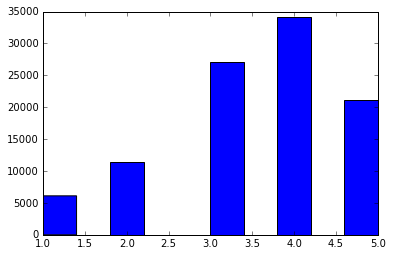

In [3]:
plt.hist(data["rating"])
plt.show()

## Sub-setting (Baseline Analysis): rating_count >= 50 

In [4]:
# count the frequency of each movie rated by user, sort by order of frequency
rating_count = data.groupby('user_id')['item_id'].size().sort_values().rename("rating_count").reset_index()
df_1 = data.merge(rating_count)
df_1.head(5)

,user_id,item_id,rating,rating_count
0,196,242,3,39
1,196,393,4,39
2,196,381,4,39
3,196,251,3,39
4,196,655,5,39


In [5]:
# subsetting rating_count >= 50      
df_1 = df_1[df_1.rating_count > 50] #same as: df_1 = df_1.loc[(df_1.rating_count >= 50)]
df_1 = df_1.drop("rating_count",1)  

In [6]:
# check sparsity after subsetting 
Number_Ratings = len(df_1)
Number_Movies = len(np.unique(df_1["item_id"]))
Number_Users = len(np.unique(df_1["user_id"]))
sparsity = (Number_Ratings/float((Number_Movies * Number_Users)))*100
print('The sparsity of MovieLens100k is ' + str(sparsity) + '%')

The sparsity of MovieLens100k is 9.32171601316%


In [8]:
#Splitting the dataset into the Training set, Validation set and Test set
from sklearn.cross_validation import train_test_split
train, test = train_test_split(df_1, test_size = 0.3, random_state = 0)
#create validation set 
train, validation = train_test_split(train, test_size = 0.25, random_state = 0) 
train_data  = gl.SFrame(train)
validation_data = gl.SFrame(validation)
test_data = gl.SFrame(test)

## Factorization Recommender (Collaborative Filtering): 

In [9]:
param = np.linspace(1e-5, 1e-1,6) 
rmse_l = [] 
for i in range (len(param)):   
    factorization_model = gl.factorization_recommender.create(train_data, 
                                                          user_id = 'user_id', item_id = 'item_id', 
                                                          target = 'rating', regularization = param[i])
    x = factorization_model.evaluate_rmse(validation_data, target = 'rating') #x.keys() to extract keys in dictionoary
    rmse_l.append(x.get('rmse_overall')) 

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.046352s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.718003                                 |

| 5       | 0.0488281         | 0.737113                                 |

| 6       | 0.0244141         | 0.777475                                 |

| 7       | 0.012207          | 0.840322                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.718003                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 123us        | 1.2598            | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 43.858ms     | 1.0657            | 1.03227               | 0.0976562   |

| 2       | 98.374ms     | 0.932847          | 0.964971              | 0.0580668   |

| 3       | 146.384ms    | 0.861173          | 0.926275              | 0.042841    |

| 4       | 190.635ms    | 0.813841          | 0.89943               | 0.0345267   |

| 5       | 243.662ms    | 0.763478          | 0.869753              | 0.029206    |

| 6       | 287.078ms    | 0.710806          | 0.837444              | 0.0254734   |

| 11      | 545.497ms    | 0.553746          | 0.731396              | 0.016168    |

| 25      | 1.16s        | 0.47127           | 0.666139              | 0.00873464  |

| 50      | 2.32s        | 0.441992          | 0.639849              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.418994

Final training RMSE: 0.621618

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.052385s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.020008 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0794502         | Not Viable                               |

| 1       | 0.0198625         | Not Viable                               |

| 2       | 0.00496564        | 1.04701                                  |

| 3       | 0.00248282        | 1.1087                                   |

| 4       | 0.00124141        | 1.15384                                  |

| 5       | 0.000620705       | 1.18975                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00496564        | 1.04701                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 1.2598            | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 29.71ms      | DIVERGED          | DIVERGED              | 0.00496564  |

| RESET   | 34.926ms     | 1.25982           | 1.12241               |             |

| 1       | 87.259ms     | 1.12159           | 1.05905               | 0.00248282  |

| 2       | 131.461ms    | 1.00711           | 1.00355               | 0.000752197 |

| 3       | 181.032ms    | 0.98446           | 0.992199              | 0.000443241 |

| 4       | 219.937ms    | 0.972683          | 0.986247              | 0.000314191 |

| 5       | 259.007ms    | 0.965008          | 0.982348              | 0.000243342 |

| 6       | 308.347ms    | 0.95943           | 0.979505              | 0.000198566 |

| 11      | 544.753ms    | 0.944052          | 0.971623              | 0.000103418 |

| 24      | 1.06s        | 0.928927          | 0.963809              | 4.60486e-05 |

| 49      | 2.20s        | 0.917982          | 0.958114              | 2.22802e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.917485

Final training RMSE: 0.957854

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.047473s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.040006 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.039735          | Not Viable                               |

| 1       | 0.00993376        | 0.981404                                 |

| 2       | 0.00496688        | 1.06414                                  |

| 3       | 0.00248344        | 1.12808                                  |

| 4       | 0.00124172        | 1.17144                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00993376        | 0.981404                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 97us         | 1.25981           | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 56.595ms     | DIVERGED          | DIVERGED              | 0.00993376  |

| RESET   | 62.859ms     | 1.25982           | 1.12242               |             |

| 1       | 106.88ms     | DIVERGED          | DIVERGED              | 0.00496688  |

| RESET   | 108.563ms    | 1.25988           | 1.12244               |             |

| 1       | 150.987ms    | 1.12199           | 1.05915               | 0.00248344  |

| 2       | 193.225ms    | 1.01211           | 1.00602               | 0.000443352 |

| 3       | 243.992ms    | 0.997661          | 0.998823              | 0.000243402 |

| 4       | 280.202ms    | 0.990055          | 0.995011              | 0.000167749 |

| 5       | 335.438ms    | 0.984988          | 0.992463              | 0.000127972 |

| 6       | 381.099ms    | 0.981231          | 0.990569              | 0.000103444 |

| 11      | 568.783ms    | 0.970447          | 0.985112              | 5.28222e-05 |

| 23      | 1.09s        | 0.959627          | 0.979605              | 2.42919e-05 |

| 48      | 2.12s        | 0.950453          | 0.974912              | 1.14301e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.949824

Final training RMSE: 0.974589

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.045647s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.060004 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0264922         | Not Viable                               |

| 1       | 0.00662306        | 1.03895                                  |

| 2       | 0.00331153        | 1.1144                                   |

| 3       | 0.00165576        | 1.16626                                  |

| 4       | 0.000827882       | 1.19881                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00662306        | 1.03895                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 101us        | 1.2598            | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 51.947ms     | DIVERGED          | DIVERGED              | 0.00662306  |

| RESET   | 57.808ms     | 1.25988           | 1.12244               |             |

| 1       | 97.301ms     | DIVERGED          | DIVERGED              | 0.00331153  |

| RESET   | 102.307ms    | 1.25985           | 1.12243               |             |

| 1       | 150.499ms    | 1.1536            | 1.07406               | 0.00165576  |

| 2       | 186.245ms    | 1.05826           | 1.02872               | 0.000295592 |

| 3       | 238.167ms    | 1.04394           | 1.02173               | 0.000162282 |

| 4       | 288.765ms    | 1.03619           | 1.01794               | 0.000111842 |

| 5       | 330.171ms    | 1.03096           | 1.01536               | 8.53221e-05 |

| 6       | 369.79ms     | 1.02703           | 1.01343               | 6.89685e-05 |

| 11      | 588.334ms    | 1.01557           | 1.00776               | 3.52177e-05 |

| 23      | 1.06s        | 1.00379           | 1.00189               | 1.6196e-05  |

| 48      | 2.09s        | 0.993571          | 0.99678               | 7.62073e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.992881

Final training RMSE: 0.996434

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.045292s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.080002 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.01987           | Not Viable                               |

| 1       | 0.0049675         | 1.07509                                  |

| 2       | 0.00248375        | 1.14201                                  |

| 3       | 0.00124187        | 1.18529                                  |

| 4       | 0.000620937       | 1.21169                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0049675         | 1.07509                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 115us        | 1.25981           | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 55.296ms     | DIVERGED          | DIVERGED              | 0.0049675   |

| RESET   | 58.423ms     | 1.2598            | 1.12241               |             |

| 1       | 106.321ms    | DIVERGED          | DIVERGED              | 0.00248375  |

| RESET   | 112.165ms    | 1.25985           | 1.12243               |             |

| 1       | 139.801ms    | 1.17365           | 1.08335               | 0.00124187  |

| 2       | 189.429ms    | 1.09032           | 1.04418               | 0.000221704 |

| 3       | 236.123ms    | 1.07669           | 1.03764               | 0.000121716 |

| 4       | 282.391ms    | 1.06921           | 1.03402               | 8.38848e-05 |

| 5       | 328.966ms    | 1.06409           | 1.03155               | 6.39942e-05 |

| 6       | 380.32ms     | 1.06023           | 1.02968               | 5.17285e-05 |

| 11      | 618.266ms    | 1.04884           | 1.02413               | 2.64144e-05 |

| 23      | 1.10s        | 1.03694           | 1.0183                | 1.21475e-05 |

| 48      | 2.16s        | 1.02646           | 1.01314               | 5.71579e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.02575

Final training RMSE: 1.01279

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.046046s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0158964         | Not Viable                               |

| 1       | 0.0039741         | 1.1013                                   |

| 2       | 0.00198705        | 1.16043                                  |

| 3       | 0.000993525       | 1.19728                                  |

| 4       | 0.000496762       | 1.21906                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0039741         | 1.1013                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 123us        | 1.25981           | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 49.698ms     | DIVERGED          | DIVERGED              | 0.0039741   |

| RESET   | 55.308ms     | 1.25988           | 1.12244               |             |

| 1       | 100.016ms    | DIVERGED          | DIVERGED              | 0.00198705  |

| RESET   | 105.762ms    | 1.25983           | 1.12242               |             |

| 1       | 131.58ms     | 1.18744           | 1.08969               | 0.000993525 |

| 2       | 162.587ms    | 1.11378           | 1.05536               | 0.000177367 |

| 3       | 194.221ms    | 1.10103           | 1.0493                | 9.73756e-05 |

| 4       | 226.105ms    | 1.09395           | 1.04592               | 6.71095e-05 |

| 5       | 271.537ms    | 1.08907           | 1.04359               | 5.11967e-05 |

| 6       | 316.641ms    | 1.08538           | 1.04182               | 4.13838e-05 |

| 11      | 499.981ms    | 1.07438           | 1.03652               | 2.1132e-05  |

| 48      | 2.08s        | 1.05237           | 1.02585               | 4.57275e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.05167

Final training RMSE: 1.02551

### Visualise the results for RMSE vs Regularization Parameters on Validation Data
The regularization parameter in GraphLab refers as “L2 Regularization on Factors”, are added to the optimization objective to prevent overfitting. The lowest RMSE value on the validation set ensures that, we locate the global minimium for calculating weights adjustments when applying methods such as stochastic gradient descent that minimises the lose function. I have divided the regularization parameter range into 5 equally spaced steps, and also ran 20 equally spaced steps. Both analysis gave the same results. 

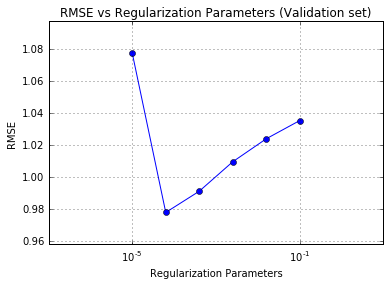

In [10]:
plt.plot(param, rmse_l, color = 'blue', linestyle = 'solid', marker = 'o')
plt.xscale('symlog')
xticks, xticklabels = plt.xticks() #save the ticks
# shift half a step to the left
xmin = (3*xticks[0] - xticks[1])/2. 
# shift half a step to the right
xmax = (3*xticks[-1] - xticks[-2])/2.

#plt.text(xmax/2, max(rmse_l), r'local minimum = {i:f}'.format(*rmse_l), fontsize = 15)
plt.xlim(xmin, xmax) #adjust the limit
plt.xticks(xticks) #reinstate the old ticks
plt.ylim(min(rmse_l) - 0.02, max(rmse_l) + 0.02)
plt.title('RMSE vs Regularization Parameters (Validation set)')
plt.xlabel('Regularization Parameters')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()     

In [11]:
print(np.column_stack((param, rmse_l)))
i = rmse_l.index(min(rmse_l))
print('\nPoint number ' + str(i+1) + 
      ' gives the minimum RMSE value of '+ str(min(rmse_l))+
      ', with Regularization value of '+ str(param[i]))

[[  1.00000000e-05   1.07705831e+00]
 [  2.00080000e-02   9.77667336e-01]
 [  4.00060000e-02   9.90913304e-01]
 [  6.00040000e-02   1.00931038e+00]
 [  8.00020000e-02   1.02365282e+00]
 [  1.00000000e-01   1.03503041e+00]]

Point number 2 gives the minimum RMSE value of 0.977667336039, with Regularization value of 0.020008


### Create Factorization Recommender using the Regularization parameter with the lowest RMSE

In [12]:
best_regular_param = 2.00080000e-02 #param[i]
factorization_model = gl.factorization_recommender.create(train_data, 
                                                          user_id = 'user_id', item_id = 'item_id', 
                                                          target = 'rating', 
                                                          side_data_factorization = False,
                                                         # user_data = users_info,
                                                         # item_data = items_info,
                                                          regularization = best_regular_param)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.046845s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.020008 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0794502         | Not Viable                               |

| 1       | 0.0198625         | Not Viable                               |

| 2       | 0.00496564        | 1.04612                                  |

| 3       | 0.00248282        | 1.10724                                  |

| 4       | 0.00124141        | 1.15241                                  |

| 5       | 0.000620705       | 1.18822                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00496564        | 1.04612                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 113us        | 1.2598            | 1.12241               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 48.171ms     | DIVERGED          | DIVERGED              | 0.00496564  |

| RESET   | 55.639ms     | 1.25983           | 1.12242               |             |

| 1       | 102.596ms    | 1.12161           | 1.05906               | 0.00248282  |

| 2       | 137.538ms    | 1.00723           | 1.00361               | 0.000752197 |

| 3       | 183.882ms    | 0.984535          | 0.992238              | 0.000443241 |

| 4       | 237.287ms    | 0.972735          | 0.986273              | 0.000314191 |

| 5       | 288.981ms    | 0.965046          | 0.982368              | 0.000243342 |

| 6       | 330.811ms    | 0.959458          | 0.979519              | 0.000198566 |

| 11      | 545.433ms    | 0.944058          | 0.971627              | 0.000103418 |

| 24      | 1.08s        | 0.92892           | 0.963805              | 4.60486e-05 |

| 49      | 2.20s        | 0.91797           | 0.958107              | 2.22802e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.917473

Final training RMSE: 0.957848

In [13]:
print('Train data set RMSE is: '+ str(factorization_model.evaluate_rmse(train_data, "rating")['rmse_overall']))
print('Test data set RMSE is: ' + str(factorization_model.evaluate_rmse(test_data,"rating")['rmse_overall'])) #

Train data set RMSE is: 0.95784804829
Test data set RMSE is: 0.978807370837


In [14]:
factorization_model.evaluate_precision_recall(test_data)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 10134
 
 Data:
 +---------+--------+----------------+-----------------+-------+
 | user_id | cutoff |   precision    |      recall     | count |
 +---------+--------+----------------+-----------------+-------+
 |    1    |   1    |      1.0       | 0.0112359550562 |   89  |
 |    1    |   2    |      0.5       | 0.0112359550562 |   89  |
 |    1    |   3    | 0.333333333333 | 0.0112359550562 |   89  |
 |    1    |   4    |      0.25      | 0.0112359550562 |   89  |
 |    1    |   5    |      0.2       | 0.0112359550562 |   89  |
 |    1    |   6    | 0.166666666667 | 0.0112359550562 |   89  |
 |    1    |   7    | 0.285714285714 | 0.0224719101124 |   89  |
 |    1    |   8    |     0.375      | 0.0337078651685 |   89  |
 |    1    |   9    | 0.333333333333 | 0.0337078651685 |   89  |
 |    1    |   10   |      0.4       | 0.0449438202247 |   89  |
 +---------+--------+

###### Visualising prediction vs ground truth (only the first 100th elements)

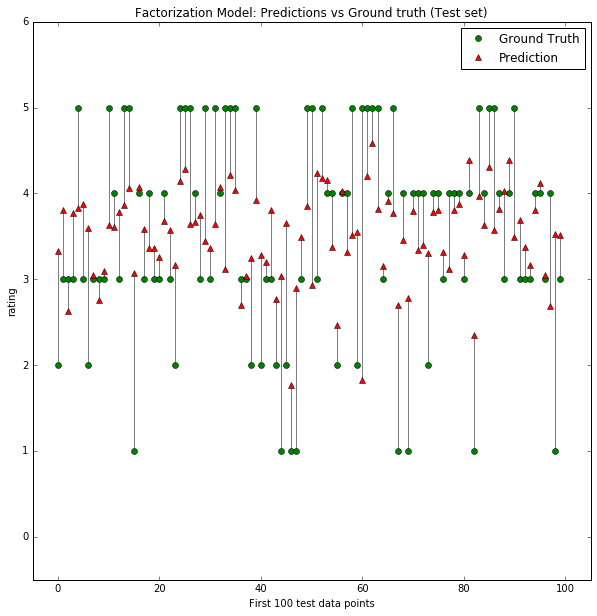

In [15]:
y_pred = factorization_model.predict(test_data)[:100]
plt.rcParams['legend.numpoints'] = 1
Y_test = test_data["rating"][:100]

fig, ax = plt.subplots(figsize =(10,10))

ax.set_xlim((-5,len(y_pred)+5))
ax.set_ylim((-0.5,6))
# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(y_pred)):
    ax.plot([i,i],[y_pred[i], Y_test[i]], c="k", linewidth=0.5)
ax.plot(Y_test,'o', label='Ground Truth', color = 'g')
ax.plot(y_pred,'^', label='Prediction', color = 'r' )
plt.xlabel('First 100 test data points')
plt.ylabel('rating')
plt.title('Factorization Model: Predictions vs Ground truth (Test set)')
plt.legend()             
plt.show() 

## Item-item Similarity Recommender
The Item Similarity Recommender in Graphlab trains the dataset, and observes the interactions between each pair of user and item. It computes the cosine similarity (dot product) between vectors (interactions). I have ran a few analysis: 1) Use the “0/1” rating model. This gave the same results comparing to without using “0/1” rating. 2) Comparing the Cosine vs  Jaccard – both gave similar set of recommendations 3) extracting the similar items (nearest neighbours), then using the nearest neighbours to re-train and creat a new model. The results gave slightly different scorings and recommendation list for each user. I then compared these results back to the original dataset, appending the item_id side information (e.g., genre matching, and user_id side information (e.g., age, sex, occupation). I have found the recommendations were reasonable. 

In [16]:
item_sim_model = gl.item_similarity_recommender.create(train_data, target = "rating", similarity_type = 'cosine')#similarity_type = 'cosine'

Recsys training: model = item_similarity

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.050675s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.146ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.996ms                             | 0                | 1               |

| 39.004ms                            | 100              | 1582            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.049243s

In [17]:
print('Train data (item-item (cosine) RMSE is: '+ str(item_sim_model.evaluate_rmse(train_data, "rating")['rmse_overall']))
print('Test data (item-item (cosine) RMSE is: ' + str(item_sim_model.evaluate_rmse(test_data,"rating")['rmse_overall']))

Train data (item-item (cosine) RMSE is: 3.49415417327
Test data (item-item (cosine) RMSE is: 3.54309594525


In [18]:
item_sim_list = item_sim_model.get_similar_items()
item_sim_list.print_rows(num_rows = 25)

+---------+---------+----------------+------+
| item_id | similar |     score      | rank |
+---------+---------+----------------+------+
|    48   |   209   | 0.330515384674 |  1   |
|    48   |   715   | 0.320109724998 |  2   |
|    48   |    64   | 0.296011269093 |  3   |
|    48   |    42   | 0.293943405151 |  4   |
|    48   |   198   | 0.293915212154 |  5   |
|    48   |    91   | 0.289852380753 |  6   |
|    48   |   180   | 0.287248194218 |  7   |
|    48   |   181   | 0.285103499889 |  8   |
|    48   |   663   | 0.279534041882 |  9   |
|    48   |   423   | 0.268353581429 |  10  |
|   217   |   559   | 0.431741476059 |  1   |
|   217   |    67   | 0.359159946442 |  2   |
|   217   |   959   | 0.345530092716 |  3   |
|   217   |   183   | 0.324136614799 |  4   |
|   217   |   172   | 0.319313168526 |  5   |
|   217   |   721   | 0.319022238255 |  6   |
|   217   |   200   | 0.306597590446 |  7   |
|   217   |   672   | 0.299738585949 |  8   |
|   217   |   569   | 0.2966219782

In [19]:
item_sim_model.evaluate_precision_recall(test_data)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 10134
 
 Data:
 +---------+--------+----------------+-----------------+-------+
 | user_id | cutoff |   precision    |      recall     | count |
 +---------+--------+----------------+-----------------+-------+
 |    1    |   1    |      1.0       | 0.0112359550562 |   89  |
 |    1    |   2    |      1.0       | 0.0224719101124 |   89  |
 |    1    |   3    |      1.0       | 0.0337078651685 |   89  |
 |    1    |   4    |      1.0       | 0.0449438202247 |   89  |
 |    1    |   5    |      0.8       | 0.0449438202247 |   89  |
 |    1    |   6    | 0.833333333333 | 0.0561797752809 |   89  |
 |    1    |   7    | 0.857142857143 | 0.0674157303371 |   89  |
 |    1    |   8    |      0.75      | 0.0674157303371 |   89  |
 |    1    |   9    | 0.777777777778 | 0.0786516853933 |   89  |
 |    1    |   10   |      0.7       | 0.0786516853933 |   89  |
 +---------+--------+

## Popularity Recommender
Create a popularity model, where all users have same recommendation based on the most popular choices

In [20]:
popularity_model = gl.popularity_recommender.create(train_data, user_id = 'user_id',
                                                    item_id = 'item_id', target = 'rating')

Recsys training: model = popularity

Preparing data set.

Data has 46315 observations with 563 users and 1582 items.

Data prepared in: 0.047352s

46315 observations to process; with 1582 unique items.

In [21]:
print('Train data RMSE is: '+ str(popularity_model.evaluate_rmse(train_data,
                                                                 "rating")['rmse_overall']))
print('Test data RMSE is: ' + str(popularity_model.evaluate_rmse(test_data,
                                                                 "rating")['rmse_overall'])) #add this ['rmse..'], output only rmse_overall

Train data RMSE is: 0.980020841695
Test data RMSE is: 1.02736492372


In [22]:
popularity_model.evaluate_precision_recall(test_data)

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 10134
 
 Data:
 +---------+--------+-----------+--------+-------+
 | user_id | cutoff | precision | recall | count |
 +---------+--------+-----------+--------+-------+
 |    1    |   1    |    0.0    |  0.0   |   89  |
 |    1    |   2    |    0.0    |  0.0   |   89  |
 |    1    |   3    |    0.0    |  0.0   |   89  |
 |    1    |   4    |    0.0    |  0.0   |   89  |
 |    1    |   5    |    0.0    |  0.0   |   89  |
 |    1    |   6    |    0.0    |  0.0   |   89  |
 |    1    |   7    |    0.0    |  0.0   |   89  |
 |    1    |   8    |    0.0    |  0.0   |   89  |
 |    1    |   9    |    0.0    |  0.0   |   89  |
 |    1    |   10   |    0.0    |  0.0   |   89  |
 +---------+--------+-----------+--------+-------+
 [10134 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and colum

In [23]:
#list the movies(item_id) with the highest mean in the dataset, confirming the recommended movies 
#have an average ratings of 5
train.groupby('item_id')['rating'].mean().sort_values(ascending = False).head(20)

item_id
1189    5.000000
935     5.000000
1410    5.000000
1459    5.000000
1642    5.000000
1302    5.000000
1398    5.000000
850     5.000000
1594    5.000000
1607    5.000000
1500    5.000000
1201    5.000000
1191    5.000000
1536    5.000000
973     5.000000
1293    5.000000
954     4.666667
1143    4.571429
408     4.549020
483     4.519231
Name: rating, dtype: float64

### Visualising prediction vs ground truth (only th first 100th elements)

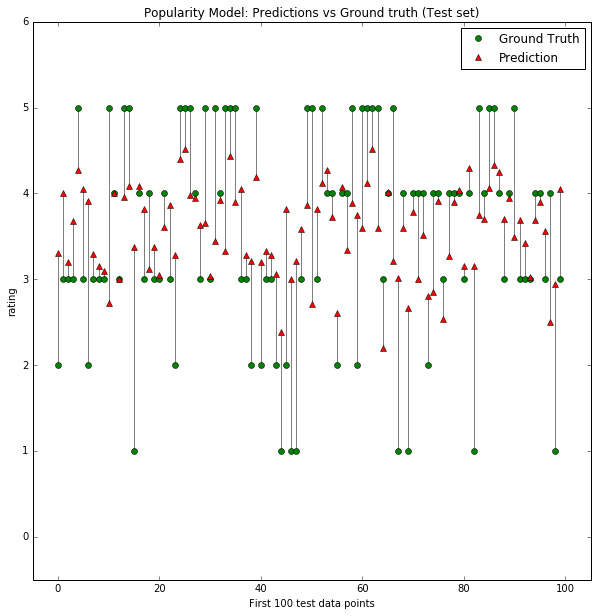

In [24]:
y_pred = popularity_model.predict(test_data)[:100]
plt.rcParams['legend.numpoints'] = 1
Y_test = test_data["rating"][:100]

fig, ax = plt.subplots(figsize =(10,10))

ax.set_xlim((-5,len(y_pred)+5))
ax.set_ylim((-0.5,6))
# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(y_pred)):
    ax.plot([i,i],[y_pred[i], Y_test[i]], c="k", linewidth=0.5)
ax.plot(Y_test,'o', label='Ground Truth', color = 'g')
ax.plot(y_pred,'^', label='Prediction', color = 'r' )
plt.xlabel('First 100 test data points')
plt.ylabel('rating')
plt.title('Popularity Model: Predictions vs Ground truth (Test set)')
plt.legend()             
plt.show() 

## Comparing performance of 3 Recommedation Systems

In [25]:
models = [popularity_model,item_sim_model,factorization_model]
model_names = ['popularity_recommender','item_similarity_recommender','factorization_recommender']
model_performance = gl.compare(test_data, models, model_names = model_names)
gl.recommender.util.compare_models(test_data, models, metric = 'precision_recall', model_names = model_names)
gl.show_comparison(model_performance, models)

PROGRESS: Evaluate model popularity_recommender

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    | 0.00355239786856 | 2.87550418371e-05 |
|   2    | 0.00532859680284 | 8.33966851135e-05 |
|   3    | 0.00414446417999 | 0.000176880839549 |
|   4    | 0.00310834813499 | 0.000176880839549 |
|   5    | 0.00284191829485 | 0.000198809221454 |
|   6    | 0.00236826524571 | 0.000198809221454 |
|   7    | 0.00253742704897 | 0.000261766498913 |
|   8    | 0.00244227353464 | 0.000287140769403 |
|   9    | 0.00236826524571 |  0.00030508217278 |
|   10   | 0.00230905861456 | 0.000317165158727 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model item_similarity_recommender

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision | 

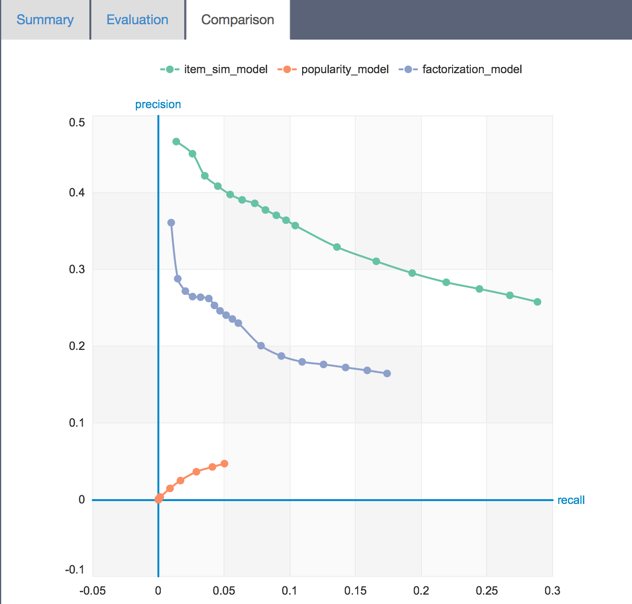

In [26]:
Image(filename='./images/PrecRecall_compare_3_models.png', width=500) 

## Observations thus far: 
The diagram above shows the performance comparison of the three models in Precision/Recall metrics at each cut off value. The default cut off value in Graphlab is set at 50. A list of cut off values refer as the values of k in “precision or recall at k”. P(k) is the vector of the k top ranked recommendations for a particular user. The precision at cut off k is defined as P(k)=|a∩P(k)|/k, and recall at cut off k is defined as R(k) = |a∩P(k)|/|a|. The set of items for that user in the ground truth dataset is denoted as “a”. As k increases (i.e., the number of recommendations by the recommender), the precision falls. But, the recall increases. The results generated from each model plotted on the graph were based on the mean values of precision and recall at each cut off point. 

The following observations are made: 
* Item similarity models perform the best, with the factorization model perform better than population model for this dataset. (sub-setting at rating_count >= 50)
* Item similarity model and factorization model have similar behaviour as the cut-off (k) increases. An inverse relationship between precision and recall is observed.
* Population model performs poorly, that suggests the assumption of population preference is homogeneous for this dataset is not applicable.  
* Looking at the best precision values, the results suggest Item Similarity model can recommend, at best, 5 (4.7) out of 10 movies are actually among top 10 movies of a user. Factorizorisation model can achieve, at best, 4 (3.6) out of 10 movies. 

### Comparing top 5 recommendations from the 3 recommndation Systems

In [27]:
popularity_recomm = popularity_model.recommend(k = 5) #pick the first 5 users, k=5 specifies top 5 recommendations for each of the 5 users 
popularity_recomm.print_rows(num_rows = 25)

+---------+---------+-------+------+
| user_id | item_id | score | rank |
+---------+---------+-------+------+
|   321   |   1398  |  5.0  |  1   |
|   321   |   1536  |  5.0  |  2   |
|   321   |   850   |  5.0  |  3   |
|   321   |   1293  |  5.0  |  4   |
|   321   |   1459  |  5.0  |  5   |
|   381   |   1398  |  5.0  |  1   |
|   381   |   1536  |  5.0  |  2   |
|   381   |   850   |  5.0  |  3   |
|   381   |   1293  |  5.0  |  4   |
|   381   |   1459  |  5.0  |  5   |
|   402   |   1398  |  5.0  |  1   |
|   402   |   1536  |  5.0  |  2   |
|   402   |   850   |  5.0  |  3   |
|   402   |   1293  |  5.0  |  4   |
|   402   |   1459  |  5.0  |  5   |
|   334   |   1398  |  5.0  |  1   |
|   334   |   1536  |  5.0  |  2   |
|   334   |   850   |  5.0  |  3   |
|   334   |   1293  |  5.0  |  4   |
|   334   |   1459  |  5.0  |  5   |
|    37   |   1398  |  5.0  |  1   |
|    37   |   1536  |  5.0  |  2   |
|    37   |   850   |  5.0  |  3   |
|    37   |   1293  |  5.0  |  4   |
|

In [28]:
factor_recomm = factorization_model.recommend(k=5)
factor_recomm.print_rows(num_rows = 25)

+---------+---------+---------------+------+
| user_id | item_id |     score     | rank |
+---------+---------+---------------+------+
|   321   |    12   | 4.40286675774 |  1   |
|   321   |   318   | 4.39445678078 |  2   |
|   321   |   174   | 4.37228880011 |  3   |
|   321   |    64   | 4.34978363596 |  4   |
|   321   |   127   | 4.34471074425 |  5   |
|   381   |    12   | 4.43269799583 |  1   |
|   381   |   174   |  4.4021200382 |  2   |
|   381   |    64   | 4.37961487405 |  3   |
|   381   |    50   | 4.37810723417 |  4   |
|   381   |   127   | 4.37454198234 |  5   |
|   402   |    12   | 4.50360085003 |  1   |
|   402   |   318   | 4.49519087307 |  2   |
|   402   |   174   |  4.4730228924 |  3   |
|   402   |    64   | 4.45051772826 |  4   |
|   402   |    98   | 4.42448110812 |  5   |
|   334   |    12   | 4.20823107593 |  1   |
|   334   |   318   | 4.19982109897 |  2   |
|   334   |   483   | 4.16582421892 |  3   |
|   334   |    64   | 4.15514795415 |  4   |
|   334   

In [29]:
item_sim_recomm = item_sim_model.recommend(k=5)
item_sim_recomm.print_rows(num_rows = 25)

+---------+---------+----------------+------+
| user_id | item_id |     score      | rank |
+---------+---------+----------------+------+
|   321   |   135   | 0.57882650332  |  1   |
|   321   |   168   | 0.574589888771 |  2   |
|   321   |   191   | 0.566128688199 |  3   |
|   321   |   174   | 0.555139512985 |  4   |
|   321   |   479   | 0.527896519605 |  5   |
|   381   |   172   | 0.561937003136 |  1   |
|   381   |   174   | 0.515160747369 |  2   |
|   381   |    98   | 0.503944057624 |  3   |
|   381   |   423   | 0.493722449938 |  4   |
|   381   |   168   | 0.473368942738 |  5   |
|   402   |   121   | 0.843327441812 |  1   |
|   402   |   174   | 0.818657805026 |  2   |
|   402   |    56   | 0.770942182839 |  3   |
|   402   |    98   | 0.752574811876 |  4   |
|   402   |   172   | 0.713890987635 |  5   |
|   334   |   172   | 0.406569795856 |  1   |
|   334   |    50   | 0.37647031272  |  2   |
|   334   |    56   | 0.368795157782 |  3   |
|   334   |    64   | 0.3355424514

## Further Analysis
Motivation: 
Using the results obtained above, to compare and understand:
* Can we improve the RMSE using the same dataset?
* How different models behave with different set of groups’ preferences?
* Is there any correlation within age groups or occupation? If so,
could we pre-process a much larger dataset in the future to save computational time? Especially in active learning – this would benefit the interactive feedbacks response time.

### Control Settings:
* Same dataset Ml-100k is used
* Same training and test split ratios are used
* Sub-setting rating_count >= 50 is used
* Regularization parameter is fixed at 2.00080000e-02

### Visualisation: 
Instead of using confusion matrix, and looking at the RMSE values alone, I was interested to understand what exactly did each model predict for each user-item pair and the respective scorings.
* The first 100 elements are chosen for ease of visualisation and provided a simplistic view on proportionality.
* Note that, Item similarity model is not applicable for this visualisation. Therefore, only Factorization Model and Population Model are compared.
* Precision and Recall metrics are used to compare 3 models.

### Limitation: 
* GraphLab library is an excellent tool but it needs to be compared with other library to verify results confidence.
* Analysis results in this case study only serve as starting points for further investigation.

## Applying side features: 
Applying side features including user info (e.g., age, sex, occupations) and item info
(e.g., genres). Attempting to improve the RMSE on factorization model (Currently
Graphlab do not support side features for other models)

In [30]:
rating_count = data.groupby('user_id')['item_id'].size().sort_values().rename("rating_count").reset_index()
df_1 = data.merge(rating_count)
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_info = pd.read_csv('u.user', sep='|', names=u_cols, encoding='latin-1')
df_1 = users_info.merge(df_1)
#Reading items file:
i_cols = ['item_id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items_info = pd.read_csv('u.item', sep='|', names=i_cols, encoding='latin-1')
items_info = items_info.drop(['movie title','release date','video release date','IMDb URL','unknown'],1)
df_1 = items_info.merge(df_1)
# subsetting rating_count >= 50      
df_1 = df_1[df_1.rating_count > 50] #same as: df_1 = df_1.loc[(df_1.rating_count >= 50)]
df_1 = df_1.drop("rating_count",1) 
#Splitting the dataset into the Training set, Validation set and Test set
from sklearn.cross_validation import train_test_split
train, test = train_test_split(df_1, test_size = 0.3, random_state = 0)
#create validation set 
train, validation = train_test_split(train, test_size = 0.25, random_state = 0) 
train_data  = gl.SFrame(train)
validation_data = gl.SFrame(validation)
test_data = gl.SFrame(test)

In [31]:
df_1.head(10)

,item_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Sci-Fi,Thriller,War,Western,user_id,age,sex,occupation,zip_code,rating
0,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,24,M,technician,85711,5
1,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,2,53,F,other,94043,4
2,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,5,33,F,other,15213,4
3,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,6,42,M,executive,98101,4
4,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,10,53,M,lawyer,90703,4
5,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,13,47,M,educator,29206,3
6,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,15,49,F,educator,97301,1
7,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,16,21,M,entertainment,10309,5
9,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,18,35,F,other,37212,5
11,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,21,26,M,writer,30068,5


In [32]:
best_regular_param = 2.00080000e-02 #param[i]
factorization_model = gl.factorization_recommender.create(train_data, 
                                                          user_id = 'user_id', item_id = 'item_id', 
                                                          target = 'rating', 
                                                          side_data_factorization = False,
                                                          #user_data = users_info,
                                                          #item_data = items_info,
                                                          regularization = best_regular_param)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46315 observations with 563 users and 1580 items.

Data prepared in: 0.162166s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.020008 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46315 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0794502         | Not Viable                               |

| 1       | 0.0198625         | Not Viable                               |

| 2       | 0.00496564        | 0.971645                                 |

| 3       | 0.00248282        | 1.0182                                   |

| 4       | 0.00124141        | 1.05973                                  |

| 5       | 0.000620705       | 1.09694                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00496564        | 0.971645                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 130us        | 1.25119           | 1.11857               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 57.05ms      | DIVERGED          | DIVERGED              | 0.00496564  |

| RESET   | 70.567ms     | 1.25113           | 1.11854               |             |

| 1       | 112.151ms    | 1.05238           | 1.02586               | 0.00248282  |

| 2       | 151.628ms    | 0.973844          | 0.986835              | 0.000752197 |

| 3       | 188.113ms    | 0.949232          | 0.974286              | 0.000443241 |

| 4       | 221.654ms    | 0.937346          | 0.968166              | 0.000314191 |

| 5       | 260.819ms    | 0.929376          | 0.964042              | 0.000243342 |

| 6       | 301.002ms    | 0.92441           | 0.961462              | 0.000198566 |

| 11      | 455.692ms    | 0.909528          | 0.953692              | 0.000103418 |

| 49      | 1.76s        | 0.886284          | 0.941426              | 2.22802e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.885744

Final training RMSE: 0.94114

In [33]:
sideFeatCoeff = factorization_model['coefficients']
sideFeatCoeff

{'intercept': 3.5249919032710797, 'item_id': Columns:
 	item_id	int
 	linear_terms	float
 	factors	array
 
 Rows: 1580
 
 Data:
 +---------+-----------------+-------------------------------+
 | item_id |   linear_terms  |            factors            |
 +---------+-----------------+-------------------------------+
 |   218   | 0.0968435257673 | [8.2422872083e-08, 5.55304... |
 |   269   |  0.480831384659 | [2.59693866411e-08, -1.094... |
 |   288   |  0.176383420825 | [4.55450788195e-08, -2.803... |
 |   231   | -0.391755342484 | [4.46760779482e-08, -1.778... |
 |   204   |  0.439309686422 | [4.40759180265e-08, -2.003... |
 |    50   |  0.591536879539 | [2.25111861596e-07, 2.7294... |
 |   1446  | 0.0420682393014 | [-1.6661834934e-07, -1.053... |
 |   443   |  0.475541740656 | [-7.38829353253e-09, 1.465... |
 |   370   | -0.194579824805 | [-2.91649140394e-08, 2.389... |
 |    82   |  0.266077578068 | [4.47246932822e-08, -2.573... |
 +---------+-----------------+-----------------------

In [34]:
print('Train data set RMSE is: '+ str(factorization_model.evaluate_rmse(train_data, "rating")['rmse_overall']))
print('Test data set RMSE is: ' + str(factorization_model.evaluate_rmse(test_data,"rating")['rmse_overall'])) #

Train data set RMSE is: 0.9411397622
Test data set RMSE is: 0.970213231272


## Analysis results:
1. Continuing from previous sections, the same regularization parameters and sub-setting at rating_count >= 50 are used. 
2. Without side features, testing with the same test and train sets. Train data RMSE is: 0.95784804829, Test data RMSE is: 0.978807370837    
3. With side features applied as shown in the code section above. This resulted in a total of 25 columns for each pair of user/item observations. I have experimented with various permutation of side features. The columns shown above gave the best result. Train data RMSE is: 0.9411397622, Test data RMSE is: 0.970213231272. 
4. The respective factors calculated for user_id, item_id and side features are shown above. 
5. I had real difficulties incorporating the side features following the GraphLab API documentation. The model appeared to be created successfully. However, on closer inspection, the model in fact did not take in any side features, resulting in factors = 0. I have to set “side_data_factorization = false” and comment out "user_id", "item_id", incorporating the side features as dataframe for it to work. Very strange!
6. The result (in 1 to 4 above) shows that including side features has improved the RMSE slightly, comparing without side features. But, with the peculiar behaviour observed in 5), further testing is required. 

## Varied degrees of sparsity in relation to all 3 models performance 

## Evaluating Sparsity, sub-setting Groups - Scientist
Factorization model performs the best. Population model responds relatively well to this data set, suggesting higher homogeneity. Interesting overlapping of performances at certain cut off points

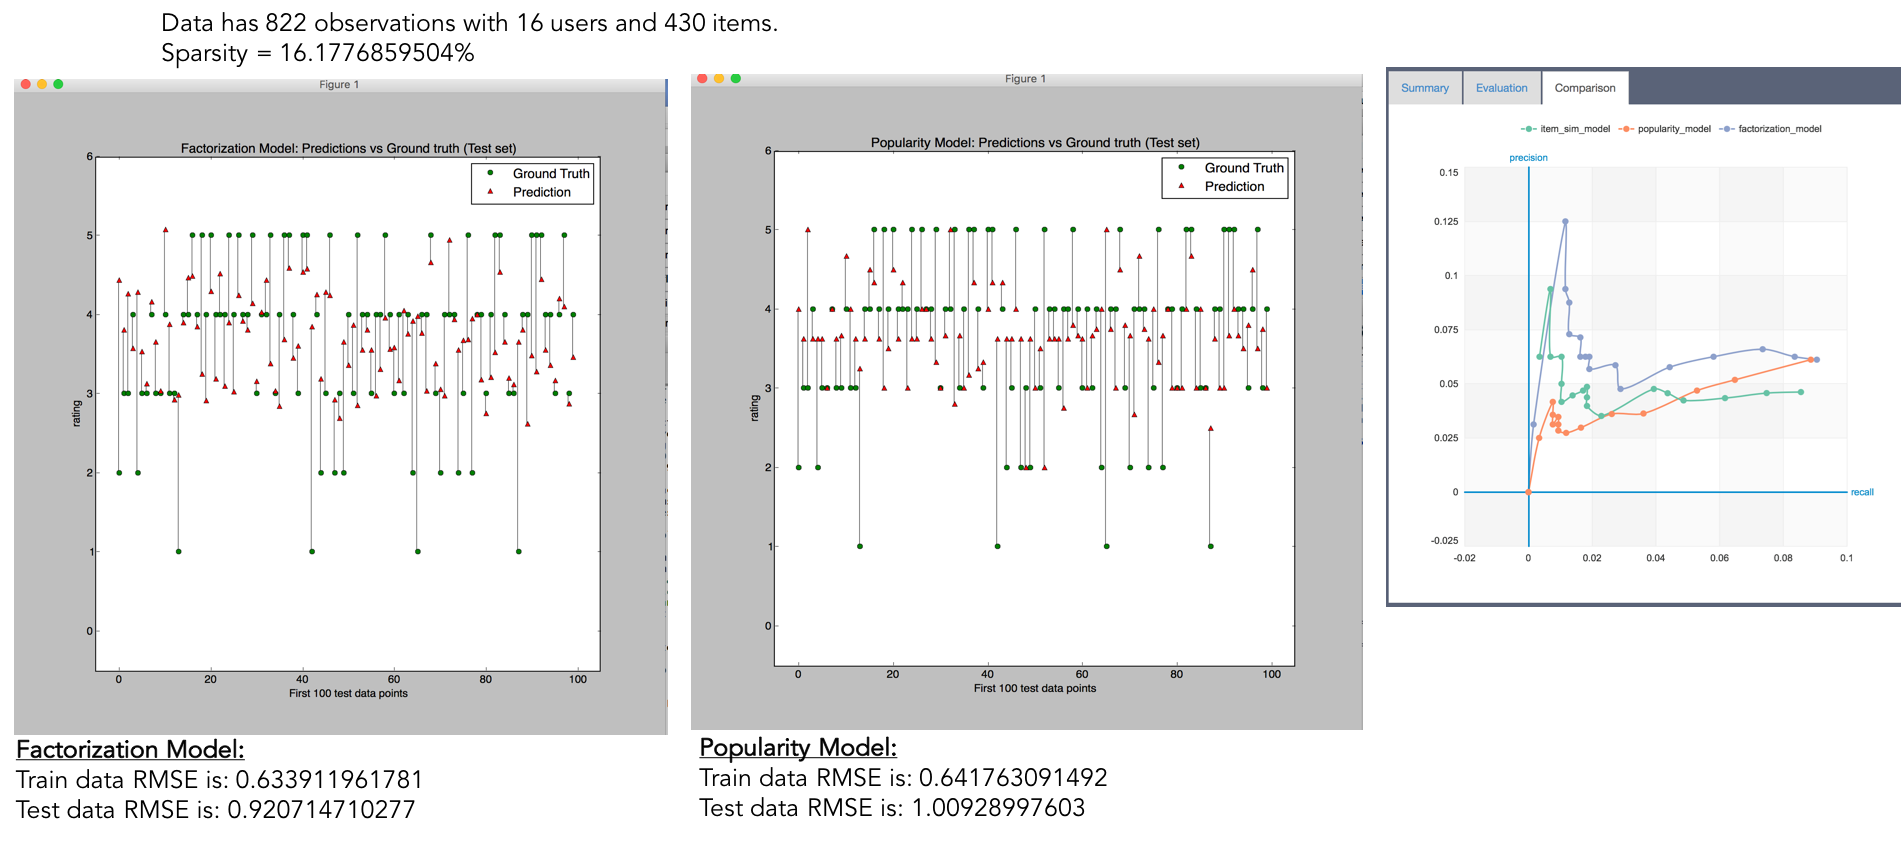

In [35]:
Image(filename='./images/scientist.png', width = 1500) 

## Evaluating Sparsity, sub-setting Groups - Scientist & Artist
Item Similarity model performs the best. Population Models performs relatively better than factorization model in the first few cut off points. At 16th cut off point, Item similarity performs similarly to factorization model. 

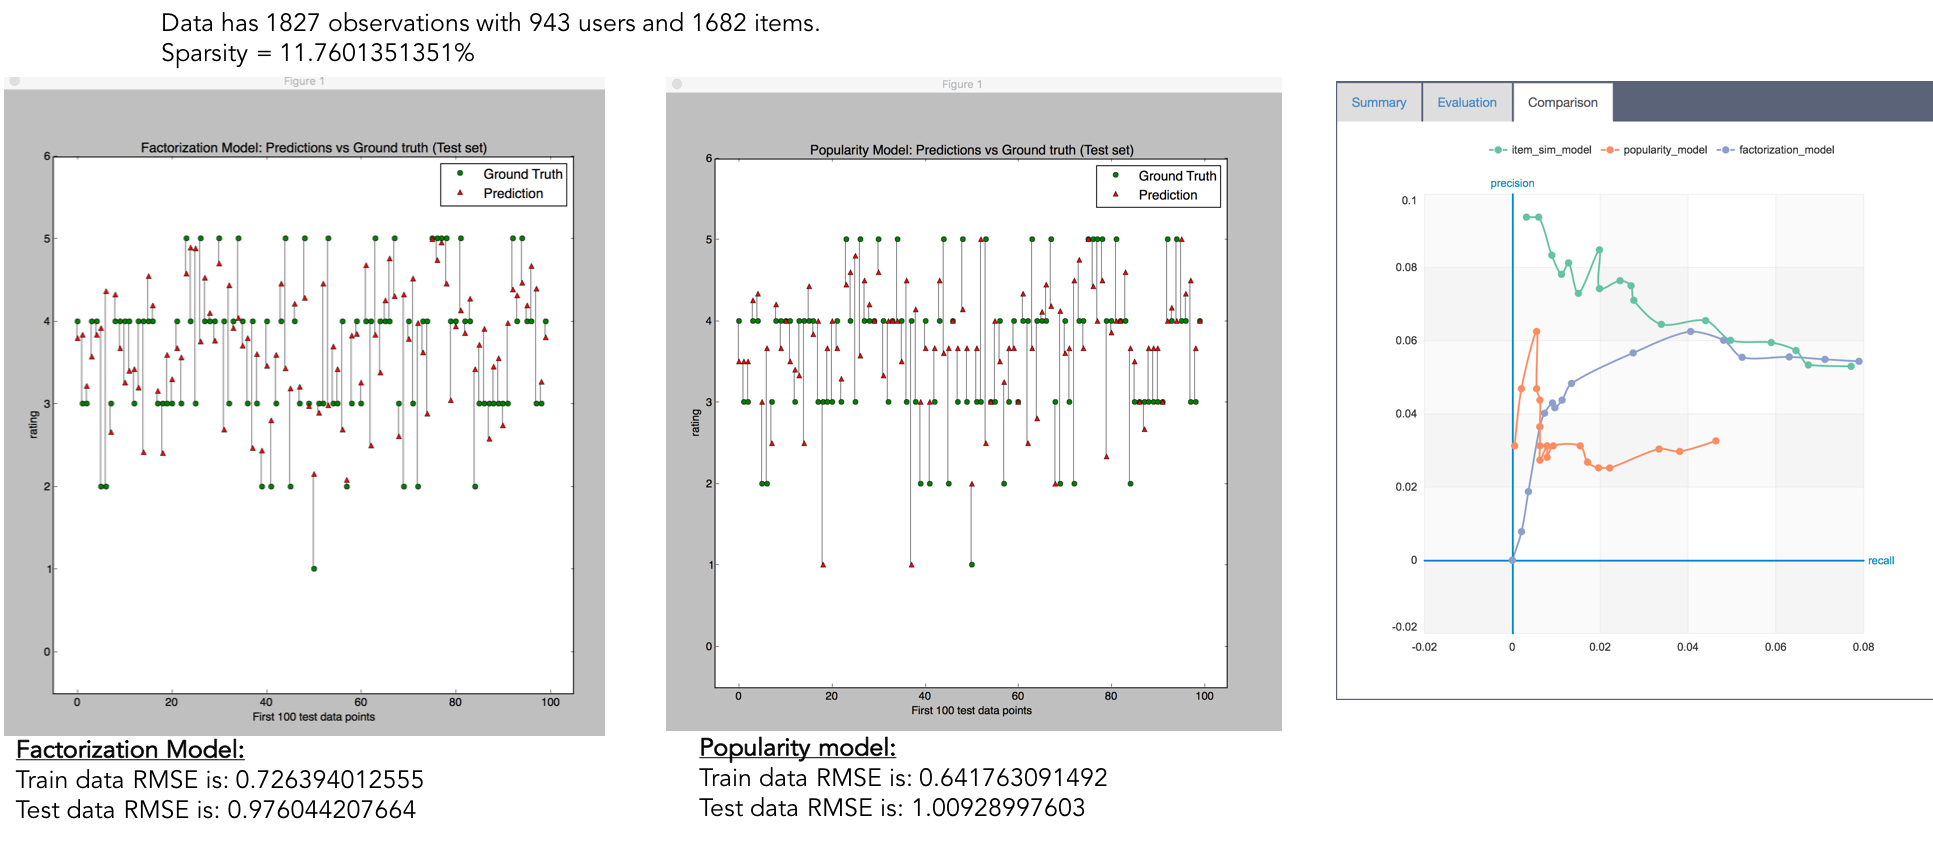

In [36]:
Image(filename='./images/scientist_artist.png', width = 1500) 

## Evaluating Sparsity, sub-setting Groups - 20 < age < 40
This set of result is consistent to the sub-setting rating_count >= 50. A significant drop in performance using factorization model. Also, notice the sharp fall after the first few cut off points for this group using Factorization model. Item similarity model performs the best in this group. 

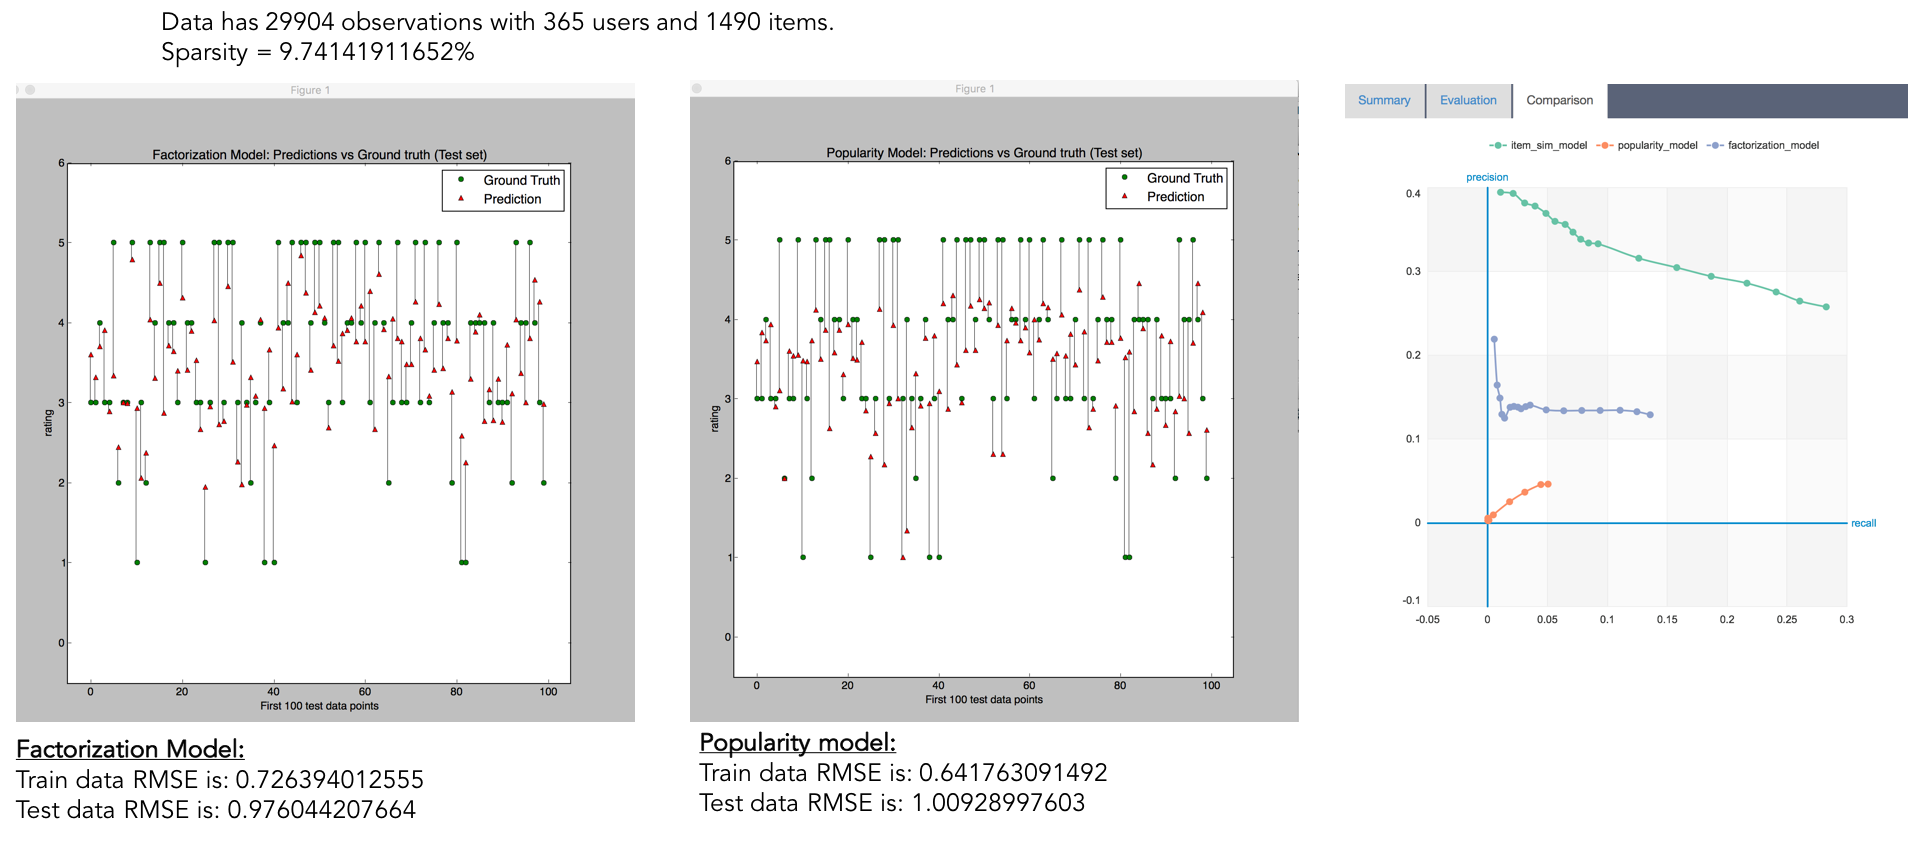

In [37]:
Image(filename='./images/age_between_20_and_40.png', width = 1500) 